In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display

from utils.diagnostics import compute_summary_statistics
from utils.dataset_utils import aggregate_results

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [2]:
model_names = [

    "ew_lo_small_sample",
    "mvo_ls_small_sample_mle_mle", "mvo_ls_small_sample_nobb_nobb", "mvo_ls_small_sample_sb_sb", "mvo_ls_small_sample_cbb_cbb",

]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

In [3]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        summary = aggregate_results(path=output_path)

        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [4]:

all_stats = {}
for model in model_names:

    portfolio_returns = torch.tensor(all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()["pnl"])
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
ew_lo_small_sample,13.072793,18.362941,0.711912,0.835148,-3.356822,-40.195822,0.527178
mvo_ls_small_sample_mle_mle,-32.127785,26.343075,-1.219591,-1.309107,-41.984526,-79.567617,0.474766
mvo_ls_small_sample_nobb_nobb,-32.253025,26.417835,-1.220881,-1.307969,-41.875620,-79.910444,0.469159
mvo_ls_small_sample_sb_sb,-28.607910,34.114639,-0.838582,-0.846368,-37.291912,-83.445055,0.475701
mvo_ls_small_sample_cbb_cbb,-31.516040,26.362117,-1.195505,-1.290502,-42.098859,-79.785104,0.472897


In [5]:
print(all_stats_df.reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
                        index &       E[R] &    Std(R) &    Sharpe &   Sortino &      AvgDD &      MaxDD &  \% Positive Ret. \\
\midrule
           ew\_lo\_small\_sample &  13.072793 & 18.362941 &  0.711912 &  0.835148 &  -3.356822 & -40.195822 &         0.527178 \\
  mvo\_ls\_small\_sample\_mle\_mle & -32.127785 & 26.343075 & -1.219591 & -1.309107 & -41.984526 & -79.567617 &         0.474766 \\
mvo\_ls\_small\_sample\_nobb\_nobb & -32.253025 & 26.417835 & -1.220881 & -1.307969 & -41.875620 & -79.910444 &         0.469159 \\
    mvo\_ls\_small\_sample\_sb\_sb & -28.607910 & 34.114639 & -0.838582 & -0.846368 & -37.291912 & -83.445055 &         0.475701 \\
  mvo\_ls\_small\_sample\_cbb\_cbb & -31.516040 & 26.362117 & -1.195505 & -1.290502 & -42.098859 & -79.785104 &         0.472897 \\
\bottomrule
\end{tabular}



## 2) Cummulative Returns of the Portfolios

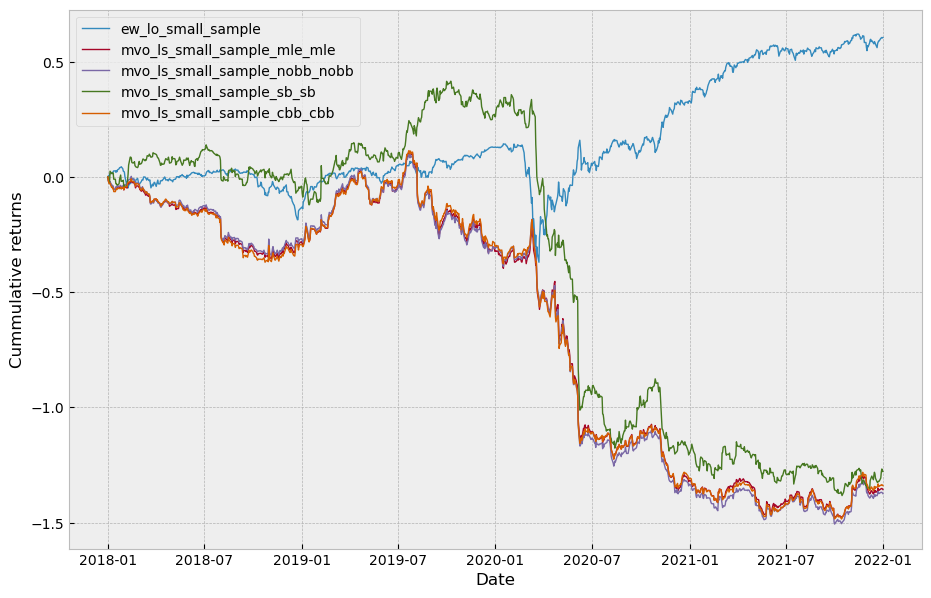

In [6]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]
    cum_pnl_df = summary_df.groupby("date").sum()[["pnl"]].loc["2018-01-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Boxplot with the Sharpe Ratio for each Monte Carlo Sample

## 4) Forecast Comparison - Diebold-Mariano Test